In [2]:
import jax
from jax import jit, grad, hessian, vmap
from jax.lax import cond
import jax.numpy as jnp
import jax.random as jr
# import jax.scipy as js

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from corner import corner

In [3]:
# see what CPU / GPU devices are available
jax.devices()

[CpuDevice(id=0)]

In [4]:
# remove 'cpu' here to run on a GPU if available
os.environ['JAX_PLATFORM_NAME'] = 'cpu'

# run in single precision
from jax import config
config.update('jax_debug_nans', False)
config.update('jax_enable_x64', False)

# Make fake data

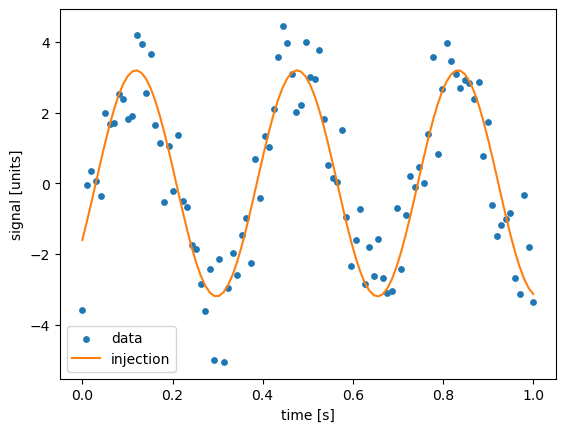

In [5]:
# time samples for data collection
t_start = 0.
t_stop = 1.
Nt = 100
times = jnp.linspace(t_start, t_stop, Nt)

# model data as sinusoid
def model(amp, freq, phase):
    return amp * jnp.sin(2. * jnp.pi * freq * times - phase)

# noise is drawn from zero-mean normal distribution
noise_stdev = 1.0
noise_key = jr.key(0)
noise = jr.normal(noise_key, (Nt,)) * noise_stdev

# injected model parameters
amp_inj = 3.2
freq_inj = 2.8
phase_inj = np.pi / 6.
x_inj = jnp.array([amp_inj, freq_inj, phase_inj])
ndim = x_inj.shape[0]

# make fake data
signal_inj = model(amp_inj, freq_inj, phase_inj)
data = signal_inj + noise
plt.scatter(times, data, color='C0', s=15, label='data')
plt.plot(times, signal_inj, color='C1', label='injection')
plt.xlabel('time [s]')
plt.ylabel('signal [units]')
plt.legend()
plt.show()

# Construct likelihood distribution

In [6]:
# noise weighted inner product
def inner(a, b):
    return jnp.sum(a * b) / noise_stdev**2.

# log-likelihood (assuming prior = 1)
def log_likelihood(x):
    signal = model(*x)
    return -0.5 * inner(data - signal, data - signal)

In [7]:
# define parameter bounds
amp_min, amp_max = 0., 10.
freq_min, freq_max = 0., 10.
phase_min, phase_max = 0., 2. * np.pi
x_min = jnp.array([amp_min, freq_min, phase_min])
x_max = jnp.array([amp_max, freq_max, phase_max])

# point in parameter space to start sampler
x0 = jr.uniform(jr.key(1), (ndim,), minval=x_min, maxval=x_max)

In [8]:
# make likelihood fast with JIT
log_likelihood_fast = jit(log_likelihood)

# compute the gradient of the posterior
grad_log_likelihood_fast = jit(jax.grad(log_likelihood))

In [9]:
%timeit log_likelihood(x0)

54.2 µs ± 863 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [10]:
%timeit log_likelihood_fast(x0)

2.94 µs ± 13.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [11]:
%timeit grad_log_likelihood_fast(x0)

11.3 µs ± 450 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


# Sample with numpyro

In [13]:
def sampling_model():

    # define uniform priors on parameters
    amp = numpyro.sample('amp', dist.Uniform(amp_min, amp_max))
    freq = numpyro.sample('freq', dist.Uniform(freq_min, freq_max))
    phase = numpyro.sample('phase', dist.Uniform(phase_min, phase_max))

    # add likelihood factor so we sample the posterior
    numpyro.factor('log_likelihood', log_likelihood_fast(jnp.array([amp, freq, phase])))

In [14]:
# define the NUTS sampler
nuts_kernel = NUTS(sampling_model)

# run MCMC
mcmc = MCMC(nuts_kernel, num_samples=10_000, num_warmup=500)
mcmc.run(jr.key(2))

# get posterior samples
HMC_samples = mcmc.get_samples()

# convert samples to multi-dimensional array instead of dictionary
HMC_samples = np.array([HMC_samples['amp'],
                        HMC_samples['freq'],
                        HMC_samples['phase']]).T
num_HMC_samples = len(HMC_samples)

sample: 100%|██████████| 10500/10500 [00:02<00:00, 5170.10it/s, 3 steps of size 3.17e-01. acc. prob=0.95] 


# Sample with Metropolis-Hastings for comparison

In [15]:
# we need the log-posterior which includes prior bounds on parameters
def ln_posterior(x):
    out_of_bounds = jnp.logical_or(jnp.any(x < x_min),
                                    jnp.any(x > x_max))
    def out_of_bounds_case():
        return -jnp.inf
    def in_bounds_case():
        return log_likelihood_fast(x)
    return cond(out_of_bounds, out_of_bounds_case, in_bounds_case)
fast_lnpost = jit(ln_posterior)

In [16]:
# simple Metropolis-Hastings MCMC for comparison
def MH_MCMC(num_samples, x0, lnpost_func):

    # initialize samples
    ndim = x0.shape[0]
    samples = np.zeros((num_samples, ndim))
    lnposts = np.zeros(num_samples)
    samples[0] = x0
    lnposts[0] = lnpost_func(samples[0])

    # get Fisher jumps
    def get_Fisher_jumps(x):
        Fisher = -hessian(lnpost_func)(x)  # automatic differentiation!
        vals, vecs = jnp.linalg.eigh(Fisher)
        jumps = jnp.array([1. / jnp.sqrt(val) * vec for val, vec in zip(vals, vecs.T)])
        return jumps
    fast_Fisher_jumps = jit(get_Fisher_jumps)

    # get differential evolution jumps
    DE_scale = 2.38 / jnp.sqrt(2. * ndim)
    def DE_jump(samples, iteration, key):
        choice_key, weight_key = jr.split(key)
        choice_ndxs = jr.choice(choice_key, iteration, (2,))
        jump = samples[choice_ndxs[0]] - samples[choice_ndxs[1]]
        jump *= jr.normal(weight_key) * DE_scale
        return jump

    # track jump acceptance rates
    num_jump_types = 2
    jump_accept_counts = np.zeros(num_jump_types)
    jump_reject_counts = np.zeros(num_jump_types)

    # jump choices
    jump_choices = np.random.choice(num_jump_types, num_samples, p=np.array([0.6, 0.4]))

    # initialize Fisher jumps
    Fisher_jumps = fast_Fisher_jumps(samples[0])

    # main MCMC loop
    for i in range(num_samples - 1):

        # update progress
        if i % (num_samples // 1000) == 0:
            print(f'{round(i / num_samples * 100, 3)}%', end='\r')
        
        # update Fisher occasionally
        if i % 10_000 == 0 and i > 100:
            x_ML_so_far = samples[jnp.argmax(lnposts[:i])]
            Fisher_jumps = fast_Fisher_jumps(x_ML_so_far)

        # jump proposal
        jump_key = jr.PRNGKey(i)
        jump_ndx = jump_choices[i]
        if jump_ndx == 0 or i < 100:  # Fisher jump
            direction_key, weight_key = jr.split(jump_key)
            jump = Fisher_jumps[jr.choice(direction_key, ndim)] * jr.normal(weight_key)
        else:
            jump = DE_jump(samples, i, jump_key)
        
        # decide to accept or reject proposal
        new_state = samples[i] + jump
        new_lnpost = lnpost_func(new_state)
        accept_prob = jnp.exp(new_lnpost - lnposts[i])
        
        if jr.uniform(jump_key) < accept_prob:  # accept
            samples[i + 1] = np.copy(new_state)
            lnposts[i + 1] = np.copy(new_lnpost)
            jump_accept_counts[jump_ndx] += 1
        else:  # reject
            samples[i + 1] = np.copy(samples[i])
            lnposts[i + 1] = np.copy(lnposts[i])
            jump_reject_counts[jump_ndx] += 1
        
    # compute acceptance rate
    jump_accept_rates = jump_accept_counts / (jump_accept_counts + jump_reject_counts)
    print('jump acceptance rates')
    print(f'Fisher: {jump_accept_rates[0]}')
    print(f'DE: {jump_accept_rates[1]}')

    return samples, lnposts

In [17]:
# run Metropolis-Hastings MCMC
num_samples = int(1e5)
MH_samples, MH_lnposts = MH_MCMC(num_samples=num_samples,
                                 x0=x_inj,
                                 lnpost_func=fast_lnpost)

jump acceptance rates
Fisher: 0.7087179999001946
DE: 0.5018303996790532


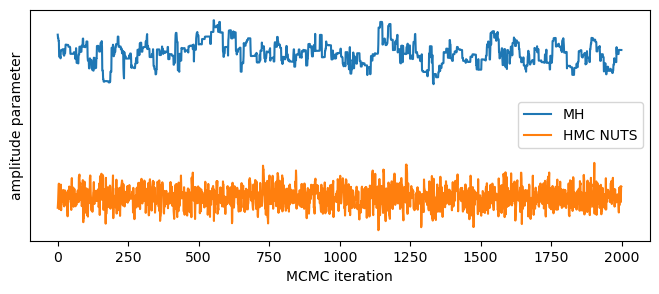

In [19]:
# plot chains for one parameter
# notice auto-correlation is much lower for HMC chain
plt.figure(figsize=(8,3))
plt.plot(MH_samples[-num_HMC_samples//5:,0], color='C0', label='MH')
plt.plot(HMC_samples[-num_HMC_samples//5:,0] - 2, color='C1', label='HMC NUTS')
plt.yticks([])
plt.xlabel('MCMC iteration')
plt.ylabel('amplitude parameter')
plt.legend()
plt.show()

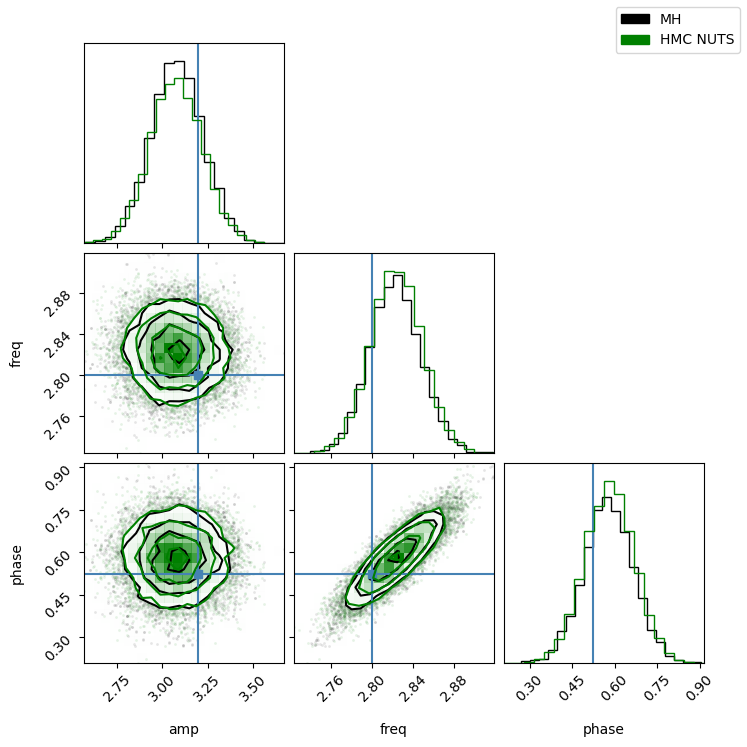

In [20]:
# thin MH samples so they're same length as HMC samples
burnin = MH_samples.shape[0] // 2
ndxs = np.random.choice(np.arange(burnin, MH_samples.shape[0]), size=num_HMC_samples, replace=False)

# plot posteriors
fig = corner(MH_samples[ndxs], 
             truths=x_inj, 
             labels=['amp', 'freq', 'phase'])

# plot HMC samples
corner(HMC_samples,
       color='green',
       fig=fig)

black_patch = mpatches.Patch(color='black', label='MH')
green_patch = mpatches.Patch(color='green', label='HMC NUTS')
fig.legend(handles=[black_patch, green_patch], loc='upper right')
plt.show()